In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
sns.set_style("white")

import scipy 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv2D,Conv1D, BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import *
from keras import backend as K



# Set random seed for reproducibility
tf.random.set_seed(42)

In [2]:
!pip install Historic-Crypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings("ignore")

from Historic_Crypto import HistoricalData

In [4]:
btc_historicals = HistoricalData('BTC-USD',86400,'2021-01-01-00-00', '2022-07-01-00-00').retrieve_data() # cyrpto name, number of seconds, start date, end date


Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2021-01-01T00:00:00
Provisional End: 2021-10-28T00:00:00
Data for chunk 1 of 2 extracted
Provisional Start: 2021-10-28T00:00:00
Provisional End: 2022-08-24T00:00:00
Data for chunk 2 of 2 extracted


In [5]:
btc_historicals.shape

(546, 5)

In [6]:
btc_historicals.tail()

,low,high,open,close,volume
time,,,,,
2022-06-27,20500.00,21520.00,21024.85,20725.17,17440.942683
2022-06-28,20164.70,21189.99,20722.95,20252.89,17658.660417
2022-06-29,19823.43,20410.91,20253.50,20094.79,18278.451859
2022-06-30,18603.00,20143.53,20098.00,19985.62,28361.458762
2022-07-01,18938.33,20879.99,19985.62,19252.76,32977.000523


In [7]:
# Check out variables
btc_historicals.dtypes

low       float64
high      float64
open      float64
close     float64
volume    float64
dtype: object

In [8]:
tst = btc_historicals

In [9]:
print('Null Values:',tst.isnull().values.sum())
print('If any NA values:', tst.isnull().values.any())

Null Values: 0
If any NA values: False


In [10]:
# Create variable '‘TOMORROW_CLOSE’' which shifts 'Close' up by 1
tst['TOMORROW_CLOSE'] = tst['close'].shift(-1,fill_value=0)

In [11]:
# drop last row because we shifted value (remember this when you add your forecasting data)
tst.drop(tst.tail(1).index,inplace=True) 

In [12]:
# Drop close column, since we created new ‘TOMORROW_CLOSE’
tst = tst.drop(columns=['close'])

In [13]:
tst.head()

,low,high,open,volume,TOMORROW_CLOSE
time,,,,,
2021-01-02,29039.00,33300.00,29413.29,46675.246521,33080.66
2021-01-03,32008.62,34810.00,32222.88,36951.716506,32019.99
2021-01-04,27678.00,33666.99,33082.84,46045.389685,34030.64
2021-01-05,29891.13,34499.67,32020.22,42282.569200,36859.26
2021-01-06,33352.54,37000.00,34043.91,45744.103200,39505.56


In [14]:
tst.shape

(545, 5)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web

In [16]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['TOMORROW_CLOSE'].rolling(window=7).mean()
    dataset['ma21'] = dataset['TOMORROW_CLOSE'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['TOMORROW_CLOSE'].ewm(span=26).mean()
    dataset['12ema'] = dataset['TOMORROW_CLOSE'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['TOMORROW_CLOSE'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['TOMORROW_CLOSE'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['TOMORROW_CLOSE']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [17]:
df = get_technical_indicators(tst)

In [18]:
df = df.dropna()
df.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,32112.01,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,32288.56,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,32261.87,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32510.82,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,30407.13,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [19]:
'''
print('Null Values:',tst.isnull().values.sum())
tst = tst.dropna()
print('Null Values:',tst.isnull().values.sum())
'''

"\nprint('Null Values:',tst.isnull().values.sum())\ntst = tst.dropna()\nprint('Null Values:',tst.isnull().values.sum())\n"

In [20]:
tst.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-02,29039.00,33300.00,29413.29,46675.246521,33080.66,NaN,NaN,33080.660000,33080.660000,0.000000,NaN,NaN,NaN,33080.660000,33079.66,10.406674
2021-01-03,32008.62,34810.00,32222.88,36951.716506,32019.99,NaN,NaN,32529.927500,32506.130417,-23.797083,NaN,NaN,NaN,32285.157500,32018.99,10.374084
2021-01-04,27678.00,33666.99,33082.84,46045.389685,34030.64,NaN,NaN,33069.118931,33101.146859,32.027929,NaN,NaN,NaN,33493.568462,34029.64,10.434987
2021-01-05,29891.13,34499.67,32020.22,42282.569200,36859.26,NaN,NaN,34128.676746,34287.436309,158.759563,NaN,NaN,NaN,35765.410250,36858.26,10.514835
2021-01-06,33352.54,37000.00,34043.91,45744.103200,39505.56,NaN,NaN,35375.598150,35705.181866,329.583716,NaN,NaN,NaN,38269.146860,39504.56,10.584171


In [21]:
tst.tail()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2022-06-26,20944.68,21866.00,21474.14,11145.888527,20725.17,20889.245714,23314.746190,23840.588485,21570.449217,-2270.139268,3996.338016,31307.422222,15322.070159,20861.413568,20724.17,9.939056
2022-06-27,20500.00,21520.00,21024.85,17440.942683,20252.89,20825.807143,22797.888571,23574.833042,21367.747799,-2207.085243,3622.579711,30043.047994,15552.729149,20455.731189,20251.89,9.916003
2022-06-28,20164.70,21189.99,20722.95,17658.660417,20094.79,20843.854286,22317.783333,23317.052076,21171.908138,-2145.143938,3244.045390,28805.874113,15829.692553,20215.103730,20093.79,9.908166
2022-06-29,19823.43,20410.91,20253.50,18278.451859,19985.62,20684.021429,21837.116667,23070.279330,20989.402270,-2080.877059,2746.066622,27329.249911,16344.983422,20062.114577,19984.62,9.902718
2022-06-30,18603.00,20143.53,20098.00,28361.458762,19252.76,20402.455714,21369.957143,22787.500120,20722.226537,-2065.273583,2243.864514,25857.686172,16882.228114,19522.544859,19251.76,9.865358


In [22]:
# Split train data (90%) and test data (10%)

train_size = int(len(tst)*0.90)
train_dataset, test_dataset = tst.iloc[:train_size],tst.iloc[train_size:]


In [23]:
print('Null Values:',test_dataset.isnull().values.sum())


Null Values: 0


In [24]:
print('Null Values:',train_dataset.isnull().values.sum())
train_dataset = train_dataset.dropna()
print('Null Values:',train_dataset.isnull().values.sum())


Null Values: 86
Null Values: 0


In [25]:
train_dataset.head()

,low,high,open,volume,TOMORROW_CLOSE,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,32112.01,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,32288.56,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,32261.87,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32510.82,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,30407.13,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [26]:
# Split train data to X and y
X_train = train_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]

# Split test data to X and y
X_test = test_dataset.drop('TOMORROW_CLOSE', axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]

In [27]:
X_train.head()

,low,high,open,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
time,,,,,,,,,,,,,,,
2021-01-22,28732.00,33867.00,30855.90,48155.721617,34259.641429,35865.701429,35377.080031,34647.900062,-729.179969,2768.237573,41402.176574,30329.226283,32345.742206,32111.01,10.376954
2021-01-23,31432.19,33488.79,32982.66,16139.814783,33755.150000,35827.982381,35096.733728,34275.485985,-821.247744,2813.115648,41454.213677,30201.751085,32307.620735,32287.56,10.382437
2021-01-24,30931.21,33086.53,32110.00,13618.800978,33131.955714,35839.500476,34843.637701,33958.909800,-884.727901,2797.194653,41433.889782,30245.111171,32277.120245,32260.87,10.381610
2021-01-25,31920.80,34888.00,32293.18,23045.662934,32645.318571,35767.128095,34638.483747,33732.009389,-906.474358,2865.171051,41497.470197,30036.785993,32432.920082,32509.82,10.389297
2021-01-26,30830.00,32960.37,32260.52,23535.838917,31917.324286,35459.883810,34271.457772,33212.512918,-1058.944854,3080.085635,41620.055080,29299.712539,31082.393361,30406.13,10.322400


In [28]:
'''
#Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)
'''

"\n#Plot train and test data\nplt.figure(figsize = (12, 6))\nplt.rcParams['figure.dpi'] = 360\nplt.plot(train_dataset.TOMORROW_CLOSE)\nplt.plot(test_dataset.TOMORROW_CLOSE)\nplt.xlabel('Date')\nplt.ylabel('Close value (US$)')\nplt.legend(['Train set', 'Test set'], loc='upper left')\nprint('Dimension of train data: ',train_dataset.shape)\nprint('Dimension of test data: ', test_dataset.shape)\n"

In [29]:
# Different scaler for input and output ----> Normalizate the data
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [30]:
# Create 3 dimensional data set 
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 15 # which means the model will make predictions of ‘TOMORROW_CLOSE’ based on the input from the 10 previous days or future days bi-lstm or bi-gru

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (455, 15, 15)
y_train.shape:  (455, 1)
X_test.shape:  (40, 15, 15)
y_test.shape:  (40, 1)


In [31]:
# Create BiLSTM model
def create_model_bilstm():
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = 256, return_sequences=True), input_shape=[X_train.shape[1], X_train.shape[2]])) 
    model.add(Dropout(0.35))
    model.add(Bidirectional(LSTM(units = 128, return_sequences=False), input_shape=[X_train.shape[1], X_train.shape[2]])) 
    model.add(Dropout(0.35))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3)) # use Adam with default parameters, learning rate, ...
    return model

In [32]:
model_bi_lstm = create_model_bilstm()

In [33]:
# Let's check the summary of our baby model
model_bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 15, 512)          557056    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,213,697
Trainable params: 1,213,697
Non-

In [34]:
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs = 55, validation_split = 0.2,batch_size = 32, shuffle = False) # no shuffer , as its time series data

Epoch 1/55
12/12 [==============================] - 20s 715ms/step - loss: 0.2308 - val_loss: 0.1912
Epoch 2/55
12/12 [==============================] - 5s 407ms/step - loss: 0.0771 - val_loss: 0.0183
Epoch 3/55
12/12 [==============================] - 5s 416ms/step - loss: 0.0475 - val_loss: 0.0181
Epoch 4/55
12/12 [==============================] - 5s 390ms/step - loss: 0.0374 - val_loss: 0.0154
Epoch 5/55
12/12 [==============================] - 4s 360ms/step - loss: 0.0263 - val_loss: 0.0144
Epoch 6/55
12/12 [==============================] - 4s 366ms/step - loss: 0.0271 - val_loss: 0.0124
Epoch 7/55
12/12 [==============================] - 3s 272ms/step - loss: 0.0265 - val_loss: 0.0113
Epoch 8/55
12/12 [==============================] - 3s 235ms/step - loss: 0.0221 - val_loss: 0.0110
Epoch 9/55
12/12 [==============================] - 3s 232ms/step - loss: 0.0214 - val_loss: 0.0098
Epoch 10/55
12/12 [==============================] - 3s 233ms/step - loss: 0.0223 - val_loss: 0.009

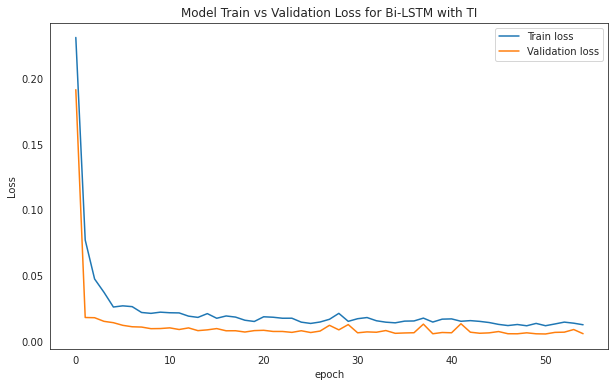

In [35]:
#Plot train and validation loss
def plot_loss (history, model_name):
    fig11 = plt.figure(figsize = (10, 6))
    plt.rcParams['figure.dpi'] = 360
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name + ' with TI')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    fig11.savefig('Model_Train_vs_Validation_Loss_for_Bi_LSTM_with_TI.png')
plot_loss (history_bi_lstm, 'Bi-LSTM')

**Afte 30 epochs, the validation errors starts to rise, which is a sign of over fitting, therefore, one has to stop the training process at 30 epochs.**

In [36]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [37]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [38]:
prediction_bi_lstm = prediction(model_bi_lstm)

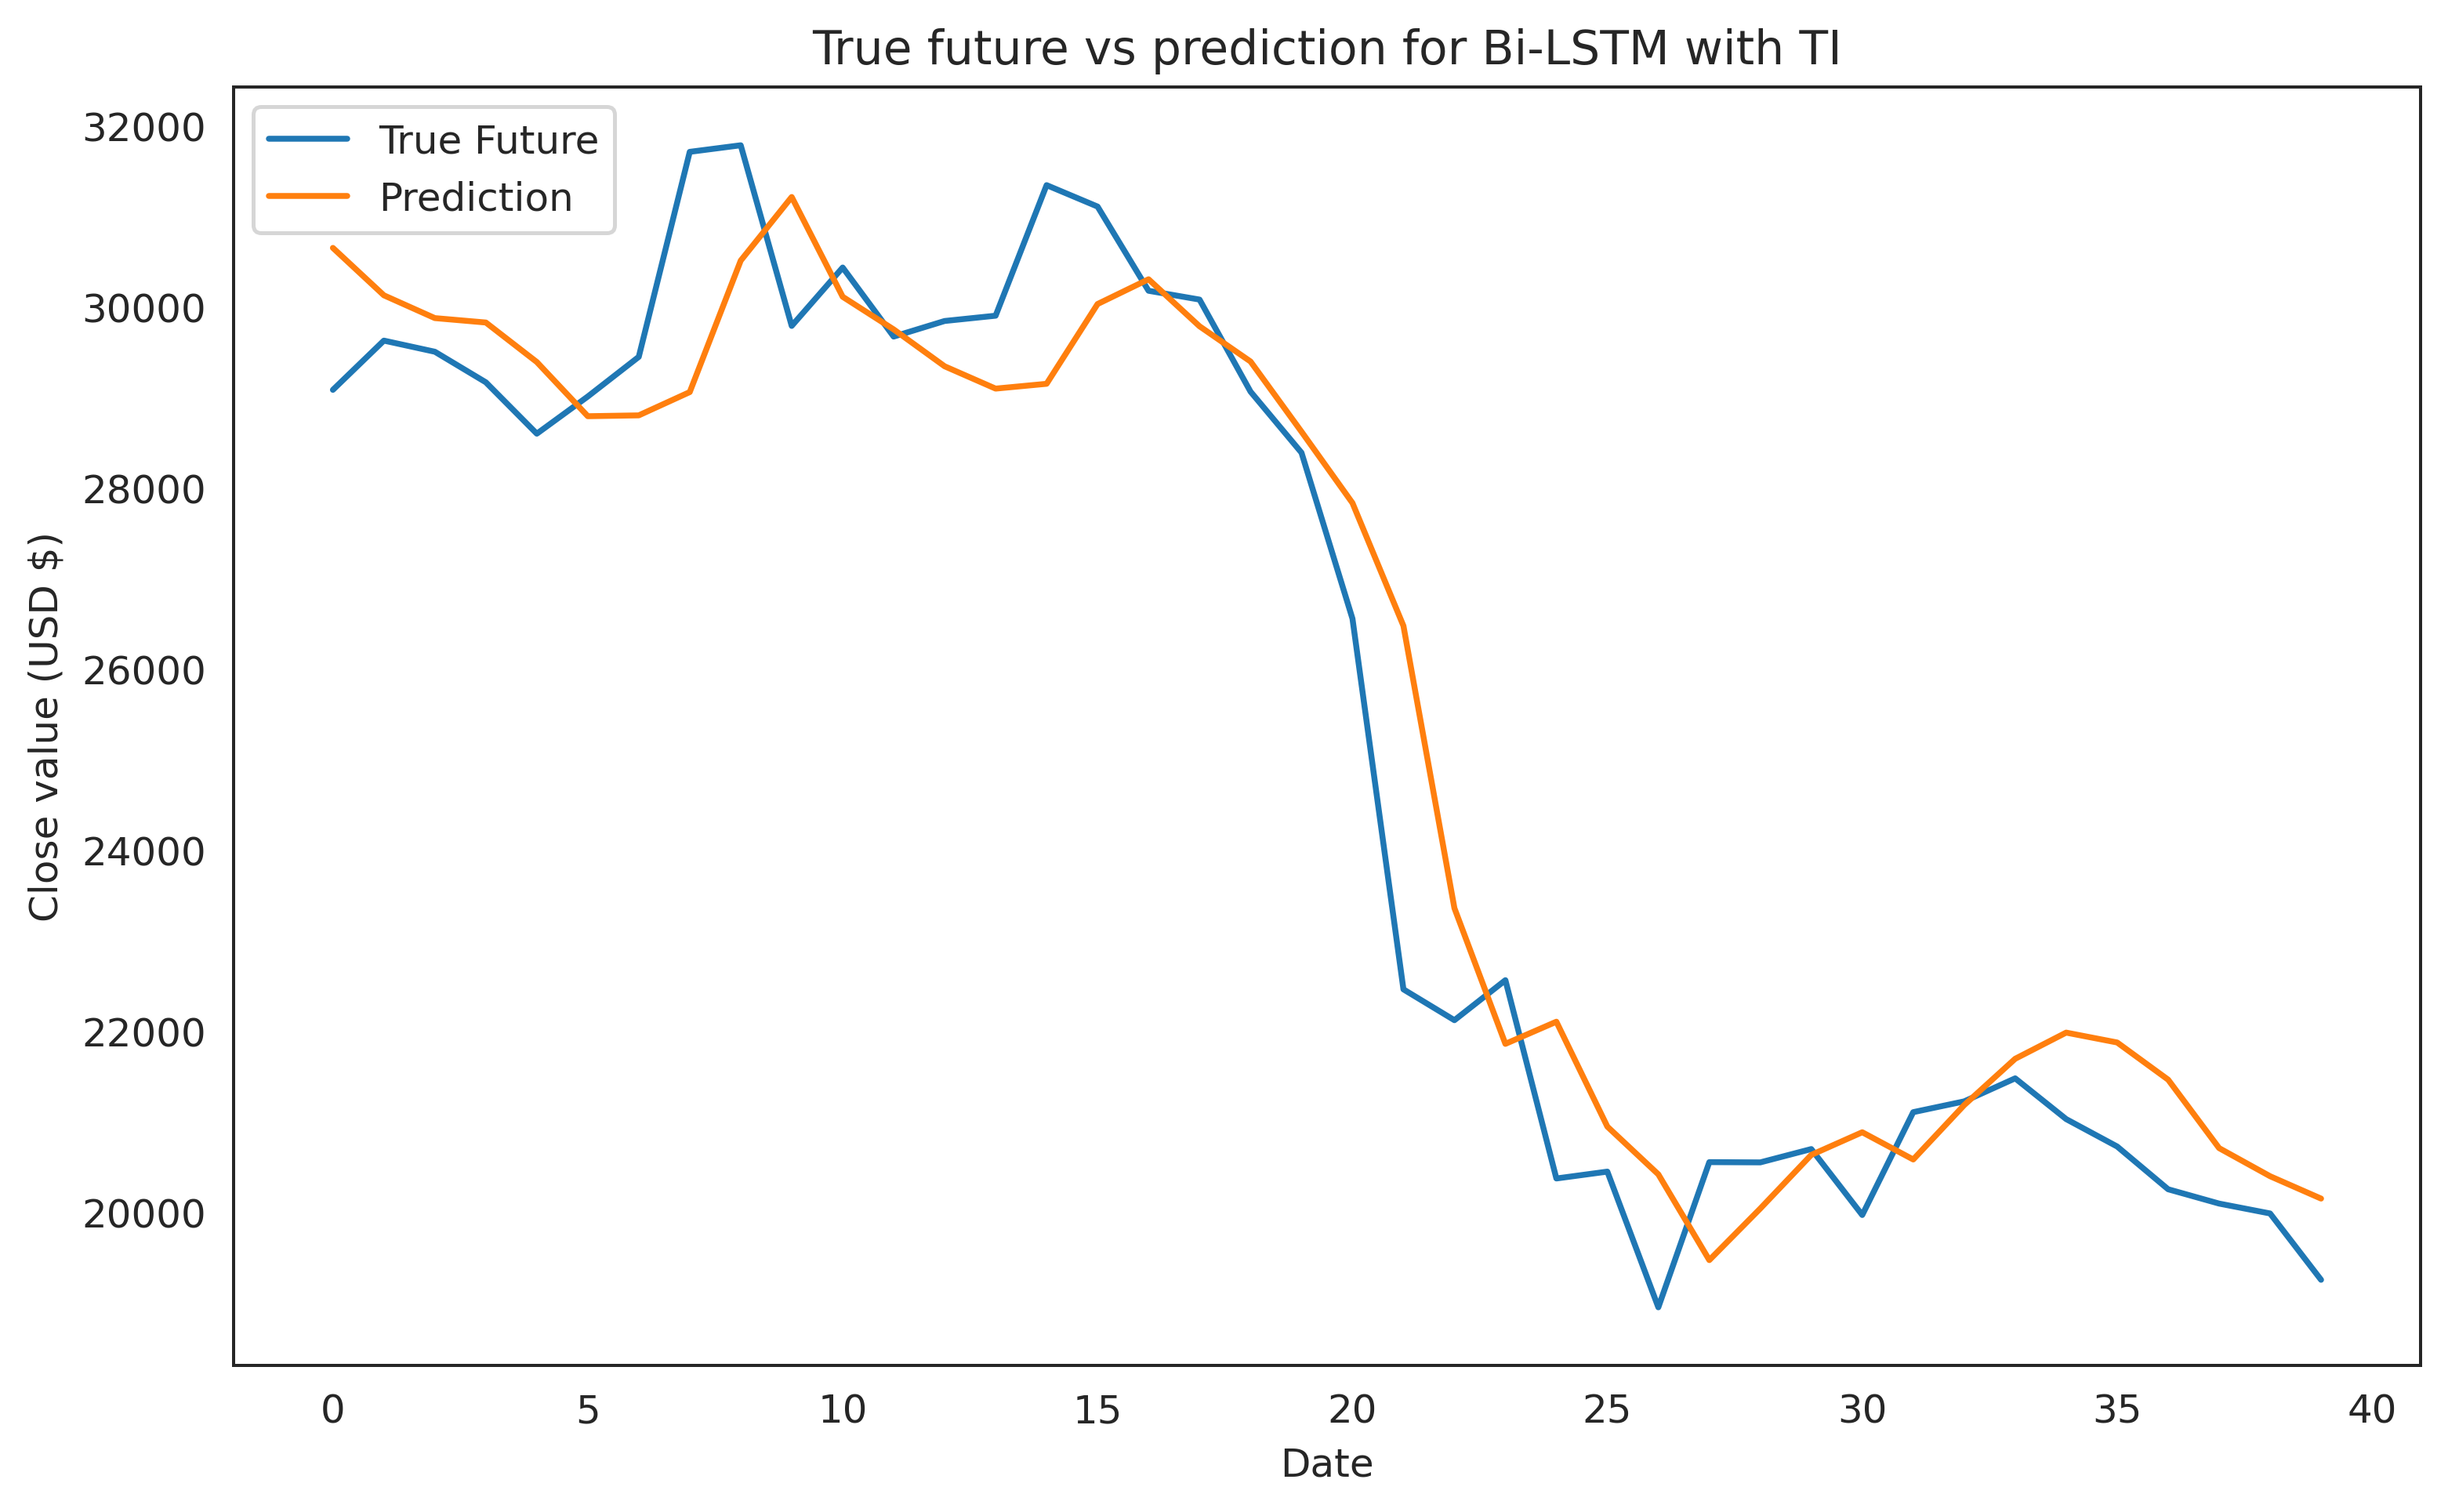

In [39]:
def plot_future(prediction, model_name, y_test):
    
    fig4 = plt.figure(figsize=(10, 6))
    plt.rcParams['figure.dpi'] = 360
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name + ' with TI')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Close value (USD $)')
    fig4.savefig('True_future_vs_prediction_for_BiLSTM_with_TI.png')
plot_future(prediction_bi_lstm, 'Bi-LSTM', y_test)

In [40]:
## Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [41]:
evaluate_prediction(prediction_bi_lstm, y_test, 'BiLSTM with TI')

BiLSTM with TI:
Mean Absolute Error: 889.7156
Root Mean Square Error: 1174.0179

